In [1]:
"""
Assessment of LANDFIRE EVT (ca. 2016) composition on FRP

This provides an initial assessment of the effects of forest type on FRP in our wildfire database

maxwell.cook@colorado.edu
"""

import os, time
import numpy as np

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from rasterstats import zonal_stats

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'

print("Complete")

Complete


## Calculate the EVT composition from LANDFIRE (ca. 2016) within VIIRS plots

As an initial assessment, we can calculate the forest composition from LANDFIRE and look at the distribution of aspen + FRP. 

In [2]:
# Load the VIIRS 375m2 "plot"
frp_plots = gpd.read_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_plots_fired_events_west_aspen.gpkg'))
print(frp_plots.head())

      VID   LATITUDE   LONGITUDE   ACQ_DATE ACQ_TIME CONFIDENCE    FRP  \
0  876446  37.507347 -112.675858 2020-11-18     1954          n  24.28   
1  876447  37.502945 -112.674408 2020-11-18     1954          n  24.28   
2  876448  37.504166 -112.669052 2020-11-18     1954          n  24.28   
3  876763  37.512333 -112.681885 2020-11-19     1936          n   7.04   
4  876764  37.513638 -112.677109 2020-11-19     1936          n   7.04   

  DAYNIGHT fired_id              ig_date  ... mn_grw_km2  mu_grw_km2  \
0        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   
1        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   
2        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   
3        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   
4        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   

            mx_grw_dte      ig_utm_x      ig_utm_y     tot_perim  pct_aspen  \
0  2020-11-17 00:00:00  4.167730e+06 -9.943

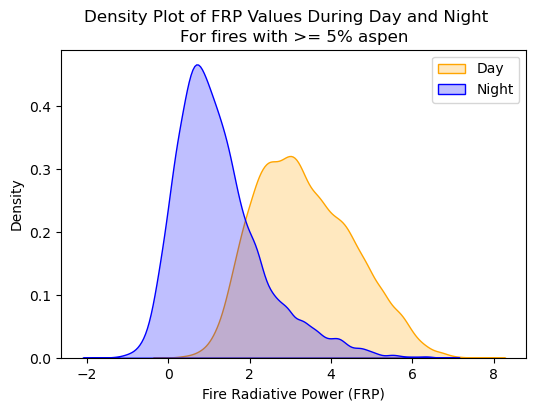

In [3]:
# Filter day and night observations
day_frp = frp_plots[frp_plots['DAYNIGHT'] == 'D']['FRP']
night_frp = frp_plots[frp_plots['DAYNIGHT'] == 'N']['FRP']

# Log scale
day_frp_log = np.log(day_frp[day_frp > 0])
night_frp_log = np.log(night_frp[night_frp > 0])

# Show the distribution of FRP values for day and night observations
plt.figure(figsize=(6, 4))

# Plotting the KDE
sns.kdeplot(day_frp_log, fill=True, color="orange", label="Day")
sns.kdeplot(night_frp_log, fill=True, color="blue", label="Night")

# Adding labels and title
plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.suptitle('Density Plot of FRP Values During Day and Night')  
plt.title('For fires with >= 5% aspen')

plt.legend()

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_frp_density_day-night.png'), dpi=300, bbox_inches='tight')

plt.show()

del day_frp, night_frp, day_frp_log, night_frp_log

In [4]:
# Calculate the percent cover of EVT types from the LANDFIRE
begin = time.time()

# LANDFIRE EVT 2016 file path
evt_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')

# Zonal statistics
zs = zonal_stats(vectors=frp_plots[['VID','geometry']], raster=evt_path, categorical=True, geojson_out=True)

print(f"Total elapsed time: {round((time.time() - begin))} seconds.")

Total elapsed time: 403 seconds.


In [5]:
# Convert the zonal statistics to a data frame for tidy
stats = gpd.GeoDataFrame(zs).fillna(0) # One column per raster category, and pixel count as value
print(stats.head())
print(len(stats['id'].unique()))

del zs

  id     type                                         properties  \
0  0  Feature  {'VID': 876446, 7011: 32, 7016: 1, 7020: 12, 7...   
1  1  Feature  {'VID': 876447, 7011: 17, 7020: 3, 7051: 109, ...   
2  2  Feature  {'VID': 876448, 7011: 5, 7051: 25, 7052: 56, 7...   
3  3  Feature  {'VID': 876763, 7011: 37, 7016: 1, 7020: 31, 7...   
4  4  Feature  {'VID': 876764, 7011: 3, 7020: 20, 7051: 179, ...   

                                            geometry  \
0  {'type': 'Polygon', 'coordinates': (((-1452319...   
1  {'type': 'Polygon', 'coordinates': (((-1452281...   
2  {'type': 'Polygon', 'coordinates': (((-1451795...   
3  {'type': 'Polygon', 'coordinates': (((-1452741...   
4  {'type': 'Polygon', 'coordinates': (((-1452304...   

                                                bbox  
0  (-1453069.902356282, 1735017.7391205789, -1452...  
1  (-1453031.003111099, 1734509.8171300525, -1452...  
2  (-1452545.3110490697, 1734562.6971642193, -145...  
3  (-1453491.9487830054, 1735660.0

In [6]:
# Explode the properties json and calculate the percent cover by class

# First get the unique ID 
stats['VID'] = stats['properties'].apply(lambda x: x.get('VID'))

# Retrieve the other properties (EVT codes)
stats['properties'] = stats['properties'].apply(lambda x: {key: val for key, val in x.items() if key != 'VID'})
stats['properties_list'] = stats['properties'].apply(lambda x: list(x.items()))

# Explode the json
props = stats.explode('properties_list').reset_index(drop=True)

# retrieve the list items as new columns
props[['EVT', 'pixel_count']] = pd.DataFrame(props['properties_list'].tolist(), index=props.index)
props = props[['VID','EVT','pixel_count']].reset_index(drop=True)

# Calculate the percent of each class
total_pixels = props.groupby(props['VID'])['pixel_count'].transform('sum')
props['total_pixels'] = total_pixels
props['pct_cover'] = (props['pixel_count'] / props['total_pixels']) * 100

print(props)

print(len(props['VID'].unique()))
print(props.columns)

del stats, total_pixels

            VID   EVT  pixel_count  total_pixels  pct_cover
0        876446  7011           32           625       5.12
1        876446  7016            1           625       0.16
2        876446  7020           12           625       1.92
3        876446  7051          181           625      28.96
4        876446  7052          137           625      21.92
...         ...   ...          ...           ...        ...
701673  1761738  7192            1           625       0.16
701674  1761738  7193           36           625       5.76
701675  1761738  7199            3           625       0.48
701676  1761738  7200            4           625       0.64
701677  1761738  9001            9           625       1.44

[701678 rows x 5 columns]
65124
Index(['VID', 'EVT', 'pixel_count', 'total_pixels', 'pct_cover'], dtype='object')


In [7]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')


In [8]:
# Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS']]
props_df = props.merge(lookup, left_on='EVT', right_on='VALUE', how='left')
print(props_df.head())
print(len(props_df['VID'].unique()))

del lookup, props

      VID   EVT  pixel_count  total_pixels  pct_cover  VALUE  \
0  876446  7011           32           625       5.12   7011   
1  876446  7016            1           625       0.16   7016   
2  876446  7020           12           625       1.92   7020   
3  876446  7051          181           625      28.96   7051   
4  876446  7052          137           625      21.92   7052   

                                            EVT_NAME  EVT_PHYS  \
0           Rocky Mountain Aspen Forest and Woodland  Hardwood   
1           Colorado Plateau Pinyon-Juniper Woodland   Conifer   
2  Inter-Mountain Basins Subalpine Limber-Bristle...   Conifer   
3  Southern Rocky Mountain Dry-Mesic Montane Mixe...   Conifer   
4  Southern Rocky Mountain Mesic Montane Mixed Co...   Conifer   

                                            EVT_GP_N           EVT_CLASS  
0               Aspen Forest, Woodland, and Parkland    Open tree canopy  
1                            Pinyon-Juniper Woodland    Open tree ca

In [9]:
# Join back the VIIRS FRP attributes
print(frp_plots.columns)

# Subset to columns we want to keep
frp_plots = frp_plots[['VID','ACQ_DATE','ACQ_TIME','ACQ_MONTH','ACQ_YEAR','CONFIDENCE','FRP','DAYNIGHT','fired_id']]

# Join back to the dataframe with EVT summary
frp_plots_evt = props_df.merge(frp_plots, left_on='VID', right_on='VID', how='left')

# Check on the results
print(frp_plots_evt.head())
print(len(frp_plots_evt['VID'].unique()))

del frp_plots, props_df

Index(['VID', 'LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'CONFIDENCE',
       'FRP', 'DAYNIGHT', 'fired_id', 'ig_date', 'ig_day', 'ig_month',
       'ig_year', 'last_date', 'event_dur', 'tot_ar_km2', 'fsr_km2_dy',
       'mx_grw_km2', 'mn_grw_km2', 'mu_grw_km2', 'mx_grw_dte', 'ig_utm_x',
       'ig_utm_y', 'tot_perim', 'pct_aspen', 'ACQ_MONTH', 'ACQ_YEAR',
       'geometry'],
      dtype='object')
      VID   EVT  pixel_count  total_pixels  pct_cover  VALUE  \
0  876446  7011           32           625       5.12   7011   
1  876446  7016            1           625       0.16   7016   
2  876446  7020           12           625       1.92   7020   
3  876446  7051          181           625      28.96   7051   
4  876446  7052          137           625      21.92   7052   

                                            EVT_NAME  EVT_PHYS  \
0           Rocky Mountain Aspen Forest and Woodland  Hardwood   
1           Colorado Plateau Pinyon-Juniper Woodland   Conifer   
2  Inter-M

In [34]:
# Create a "pct_forest" class
print(frp_plots_evt['EVT_CLASS'].unique())

forest_classes = ['Open tree canopy', 'Closed tree canopy', 'Sparse tree canopy']

frp_plots_forest = frp_plots_evt[frp_plots_evt['EVT_NAME'].isin(forest_classes)]

# Create a new DataFrame to calculate percent forest 
forest_cover = (
    frp_plots_evt[['VID', 'EVT_CLASS', 'pct_cover']]
    .pivot_table(index='VID', columns='EVT_CLASS', values='pct_cover', aggfunc='sum', fill_value=0)
)

# Now, create the 'pct_aspen' and 'pct_lodgepole' columns by summing across the relevant EVT_NAMEs
forest_cover['pct_forest'] = forest_cover[forest_classes].sum(axis=1)

# Merge back to the main data frame
frp_plots_evt = frp_plots_evt.merge(forest_cover[['pct_forest']], on='VID')
print(frp_plots_evt.head())

del frp_plots_forest, forest_cover

['Open tree canopy' 'Closed tree canopy' 'Shrubland'
 'No Dominant Lifeform' 'Herbaceous-grassland' 'Sparsely vegetated'
 'Sparse tree canopy' 'Non-vegetated' 'Dwarf-shrubland'
 'Herbaceous-shrub-steppe']
      VID   EVT  pixel_count  total_pixels  pct_cover  VALUE  \
0  876446  7011           32           625       5.12   7011   
1  876446  7016            1           625       0.16   7016   
2  876446  7020           12           625       1.92   7020   
3  876446  7051          181           625      28.96   7051   
4  876446  7052          137           625      21.92   7052   

                                            EVT_NAME  EVT_PHYS  \
0           Rocky Mountain Aspen Forest and Woodland  Hardwood   
1           Colorado Plateau Pinyon-Juniper Woodland   Conifer   
2  Inter-Mountain Basins Subalpine Limber-Bristle...   Conifer   
3  Southern Rocky Mountain Dry-Mesic Montane Mixe...   Conifer   
4  Southern Rocky Mountain Mesic Montane Mixed Co...   Conifer   

             

In [10]:
# Create a subset with just aspen EVT types
# Identify classes with 'aspen' in the EVT_NAME
aspen_classes = frp_plots_evt[frp_plots_evt['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(aspen_classes)

# Now filter to retain just the aspen composition in FRP observations
frp_plots_aspen = frp_plots_evt[frp_plots_evt['EVT_NAME'].isin(aspen_classes)]

# What percent of FRP observations have an aspen component?
len(frp_plots_aspen['VID'].unique()) / len(frp_plots_evt['VID'].unique()) * 100

['Rocky Mountain Aspen Forest and Woodland'
 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland']


79.93980713715374

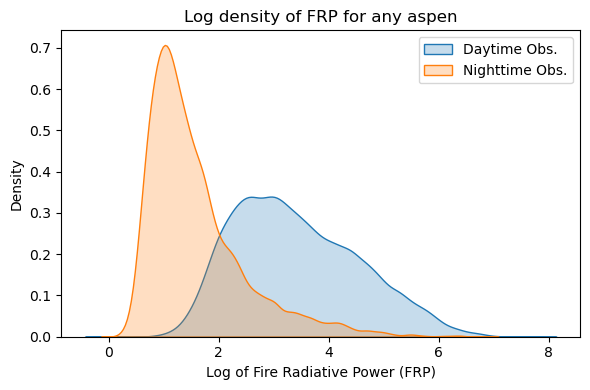

In [13]:
plt.figure(figsize=(6, 4))

frp_plots_aspen_d = frp_plots_aspen[frp_plots_aspen['DAYNIGHT'] == 'D']
frp_plots_aspen_n = frp_plots_aspen[frp_plots_aspen['DAYNIGHT'] == 'N']

# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(np.log1p(frp_plots_aspen_d['FRP']), fill=True, label="Daytime Obs.")
sns.kdeplot(np.log1p(frp_plots_aspen_n['FRP']), fill=True, label="Nighttime Obs.")

# Set plot title and axis labels
plt.title('Log density of FRP for any aspen')
plt.xlabel('Log of Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_frp_density_aspen-any_day-night.png'), dpi=300, bbox_inches='tight')

plt.show()

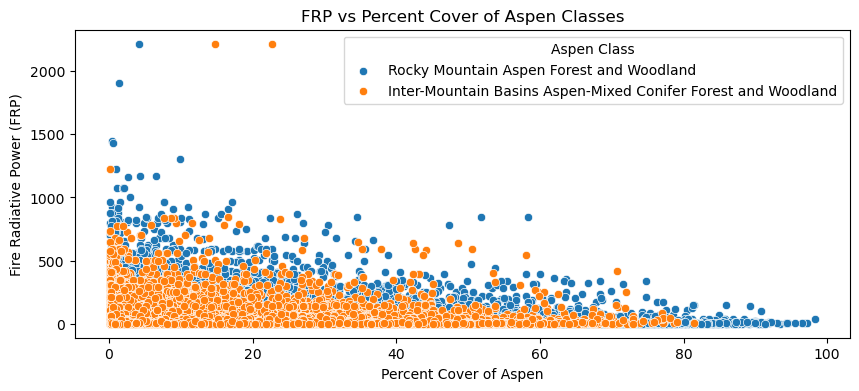

In [14]:
plt.figure(figsize=(10, 4))

frp_plots_aspen_ = frp_plots_aspen[frp_plots_aspen['FRP'] > 0]

for aspen_class in aspen_classes:
    subset = frp_plots_aspen_[frp_plots_aspen_['EVT_NAME'] == aspen_class]
    sns.scatterplot(x='pct_cover', y='FRP', data=subset, label=aspen_class)

plt.title('FRP vs Percent Cover of Aspen Classes')
plt.xlabel('Percent Cover of Aspen')
plt.ylabel('Fire Radiative Power (FRP)')
plt.legend(title='Aspen Class')

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_frp_scatterplot.png'), dpi=300, bbox_inches='tight')

plt.show()

del frp_plots_aspen_

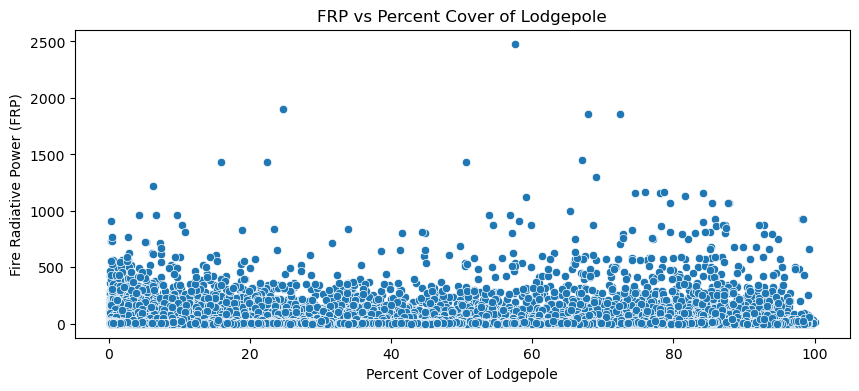

In [17]:
# Create a subset with just aspen EVT types
# Identify classes with 'aspen' in the EVT_NAME
lodgepole = frp_plots_evt[frp_plots_evt['EVT_NAME'] == "Rocky Mountain Lodgepole Pine Forest"]

plt.figure(figsize=(10, 4))

sns.scatterplot(x='pct_cover', y='FRP', data=lodgepole)

plt.title('FRP vs Percent Cover of Lodgepole')
plt.xlabel('Percent Cover of Lodgepole')
plt.ylabel('Fire Radiative Power (FRP)')

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_frp_scatterplot.png'), dpi=300, bbox_inches='tight')

plt.show()

In [18]:
# Spruce-fir
spruce_classes = frp_plots_evt[frp_plots_evt['EVT_NAME'].str.contains('spruce', case=False, na=False)]['EVT_NAME'].unique()
print(spruce_classes)
# Ponderosa
ponderosa_classes = frp_plots_evt[frp_plots_evt['EVT_NAME'].str.contains('ponderosa', case=False, na=False)]['EVT_NAME'].unique()
print(ponderosa_classes)
# # Conifer-dominated classes
# conifer_classes = frp_plots_evt[frp_plots_evt['EVT_PHYS'] == "Conifer"]['EVT_NAME'].unique()
# print(conifer_classes)

['Rocky Mountain Subalpine Mesic-Wet Spruce-Fir Forest and Woodland'
 'Rocky Mountain Subalpine Dry-Mesic Spruce-Fir Forest and Woodland']
['Southern Rocky Mountain Ponderosa Pine Woodland'
 'Southern Rocky Mountain Ponderosa Pine Savanna'
 'Northern Rocky Mountain Ponderosa Pine Woodland and Savanna']


20.94225663716814
62.109353481254786
54.19307594615189
55.73306748466258


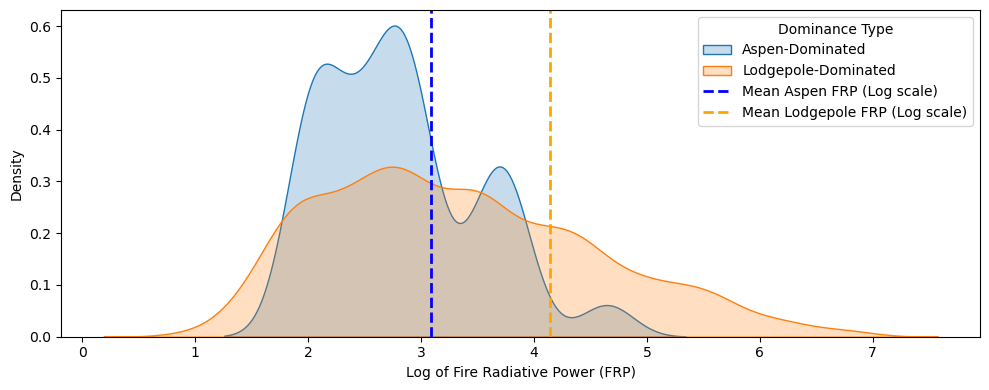

In [36]:
aspen_classes = ['Rocky Mountain Aspen Forest and Woodland',
                 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland']
lodgepole_classes = "Rocky Mountain Lodgepole Pine Forest"

# Create a new DataFrame to calculate percent cover for each EVT_NAME per VID
evt_cover = (
    frp_plots_evt[['VID', 'EVT_NAME', 'pct_cover']]
    .pivot_table(index='VID', columns='EVT_NAME', values='pct_cover', aggfunc='sum', fill_value=0)
)

# Now, create the 'pct_aspen' and 'pct_lodgepole' columns by summing across the relevant EVT_NAMEs
evt_cover['pct_aspen'] = evt_cover[aspen_classes].sum(axis=1)
evt_cover['pct_lodgepole'] = evt_cover[lodgepole_classes]
evt_cover['pct_spruce_fir'] = evt_cover[spruce_classes].sum(axis=1)
evt_cover['pct_ponderosa'] = evt_cover[ponderosa_classes].sum(axis=1)

# Merge back to the main data frame
frp_plots_evt = frp_plots_evt.merge(evt_cover[['pct_aspen', 'pct_lodgepole', 'pct_spruce_fir', 'pct_ponderosa']], on='VID')

# Only daytime observations
frp_plots_evt_ = frp_plots_evt[frp_plots_evt['DAYNIGHT'] == 'D']

# create the dataframes for dominant types
aspen_dominated = frp_plots_evt_[frp_plots_evt_['pct_aspen'] > 90]
lodgepole_dominated = frp_plots_evt_[frp_plots_evt_['pct_lodgepole'] > 90]
spruce_fir_dominated = frp_plots_evt_[frp_plots_evt_['pct_spruce_fir'] > 90]
ponderosa_dominated = frp_plots_evt_[frp_plots_evt_['pct_ponderosa'] > 90]

# Print the means
print(aspen_dominated['FRP'].mean())
print(lodgepole_dominated['FRP'].mean())
print(spruce_fir_dominated['FRP'].mean())
print(ponderosa_dominated['FRP'].mean())

# Plot the density distributions
plt.figure(figsize=(10, 4))

# Plot the KDE for aspen-dominated observations
# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(np.log1p(aspen_dominated['FRP']), fill=True, label='Aspen-Dominated')
sns.kdeplot(np.log1p(lodgepole_dominated['FRP']), fill=True, label='Lodgepole-Dominated')
# sns.kdeplot(np.log1p(spruce_fir_dominated['FRP']), fill=True, label='Spruce-Fir-Dominated')
# sns.kdeplot(np.log1p(ponderosa_dominated['FRP']), fill=True, label='Ponderosa-Dominated')

# Draw a dashed line at the mean FRP value 
plt.axvline(np.log1p(aspen_dominated['FRP'].mean()), color='blue', linestyle='dashed', linewidth=2, label=f'Mean Aspen FRP (Log scale)')
plt.axvline(np.log1p(lodgepole_dominated['FRP'].mean()), color='orange', linestyle='dashed', linewidth=2, label=f'Mean Lodgepole FRP (Log scale)')
# plt.axvline(np.log1p(spruce_fir_dominated['FRP'].mean()), color='green', linestyle='dashed', linewidth=2, label=f'Mean Spruce-Fir FRP (Log scale)')
# plt.axvline(np.log1p(ponderosa_dominated['FRP'].mean()), color='red', linestyle='dashed', linewidth=2, label=f'Mean Ponderosa FRP (Log scale)')

# Set plot title and axis labels
plt.xlabel('Log of Fire Radiative Power (FRP)')
plt.ylabel('Density')

# Place the legend outside the plot to avoid covering the data
plt.legend(title='Dominance Type', loc='upper right')

plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_vs_lodgepole.png'), dpi=300, bbox_inches='tight')

plt.show()

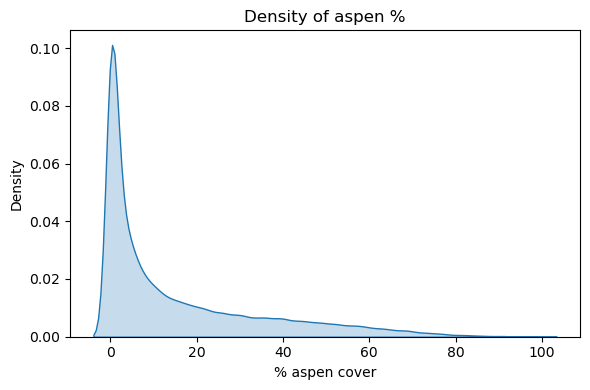

In [37]:
# Determine the distribution of aspen percent cover
plt.figure(figsize=(6, 4))

# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(frp_plots_evt['pct_aspen'], fill=True)

# Set plot title and axis labels
plt.title('Density of aspen %')
plt.xlabel('% aspen cover')
plt.ylabel('Density')
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_density.png'), dpi=300, bbox_inches='tight')

plt.show()

59.13303035136976
54.80247527296082


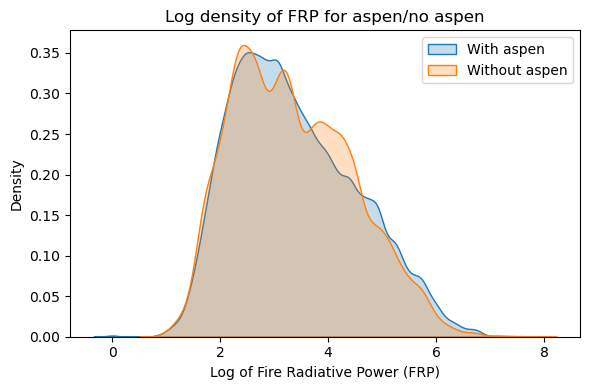

In [48]:
# Density plot of forest observations with aspen and without aspen
forested = frp_plots_evt[frp_plots_evt['pct_forest'] > 50]
forested = forested[forested['DAYNIGHT'] == 'D']

with_aspen = forested[forested['pct_aspen'] > 10]
without_aspen = forested[forested['pct_aspen'] == 0]

print(with_aspen['FRP'].mean())
print(without_aspen['FRP'].mean())

# Plot it
plt.figure(figsize=(6, 4))

# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(np.log1p(with_aspen['FRP']), fill=True, label="With aspen")
sns.kdeplot(np.log1p(without_aspen['FRP']), fill=True, label="Without aspen")

# Set plot title and axis labels
plt.title('Log density of FRP for aspen/no aspen')
plt.xlabel('Log of Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_frp_density_aspen-no_aspen.png'), dpi=300, bbox_inches='tight')

plt.show()

del forested, with_aspen, without_aspen

Aspen_Cover_Class
Medium    461975
Low       155924
High       83779
Name: count, dtype: int64


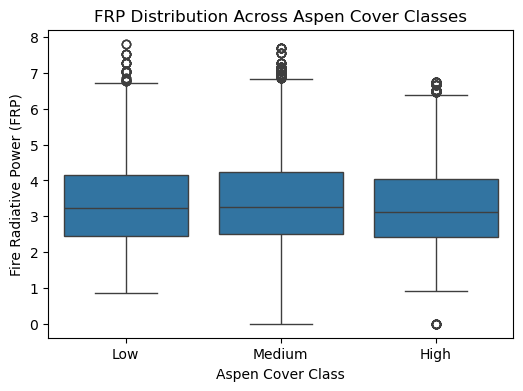

In [58]:
# Forested plots

# Define breaks for the data
quantiles = frp_plots_evt['pct_aspen'].quantile([0.22, 0.88])

# Define the bins and labels
bins = [-np.inf, quantiles[0.22], quantiles[0.88], np.inf]
labels = ['Low', 'Medium', 'High']

# Create a new column in the DataFrame with the cover categories
frp_plots_evt['Aspen_Cover_Class'] = pd.cut(frp_plots_evt['pct_aspen'], bins=bins, labels=labels)

# Verify the categories
print(frp_plots_evt['Aspen_Cover_Class'].value_counts())

frp_plots_evt['log_FRP'] = np.log1p(frp_plots_evt_['FRP'])

# Now create the boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x='Aspen_Cover_Class', y='log_FRP', data=frp_plots_evt[frp_plots_evt['pct_forest'] > 50], order=['Low', 'Medium', 'High'])
plt.title('FRP Distribution Across Aspen Cover Classes')
plt.xlabel('Aspen Cover Class')
plt.ylabel('Fire Radiative Power (FRP)')

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_classes_boxplot.png'), dpi=300, bbox_inches='tight')

plt.show()

## Investigate the relationship between EVT (class, percent cover, etc) on FRP

In [36]:
# Create a "pct_forest" column using the EVT_PHYS
print(frp_plots_evt_['EVT_CLASS'].unique())

['Open tree canopy' 'Closed tree canopy' 'Shrubland'
 'No Dominant Lifeform' 'Herbaceous-grassland' 'Sparsely vegetated'
 'Sparse tree canopy' 'Dwarf-shrubland' 'Non-vegetated'
 'Herbaceous-shrub-steppe']


## Create a daily summary data frame from the FRP observations

Grouping by FIRED ID and acquisition date, calculate the daily mean FRP. Also calculate the EVT cover across observations/days. This sets us up for the sequential autoregression analysis.

In [50]:
# Get the daily mean FRP
frp_daily = frp_plots_evt_.groupby(['fired_id', 'ACQ_DATE'])['FRP'].mean().reset_index()
# print(frp_daily.head())

# Get the daily EVT summaries across FRP observations
total_pixels = frp_plots_evt_.groupby(
    ['fired_id','ACQ_DATE','EVT_NAME']
)['total_pixels'].sum().reset_index()

# Now, for each EVT_NAME, calculate the percent cover of that EVT per day per fire
pixel_count = frp_plots_evt_.groupby(
    ['fired_id','ACQ_DATE','EVT_NAME']
)['pixel_count'].sum().reset_index()

# Merge the total_pixels data with the pixel_count data
evt_daily = pixel_count.merge(total_pixels, on=['fired_id','ACQ_DATE','EVT_NAME'])

evt_daily['pct_cover'] = (evt_daily['pixel_count'] / evt_daily['total_pixels']) * 100
# print(evt_daily.head())

# Merge the two dataframes
daily = evt_daily.merge(frp_daily, on=['fired_id','ACQ_DATE'], how='left')
print(daily.head())

  fired_id   ACQ_DATE                                           EVT_NAME  \
0   189371 2018-06-28  Colorado Plateau Mixed Bedrock Canyon and Tabl...   
1   189371 2018-06-28           Colorado Plateau Pinyon-Juniper Woodland   
2   189371 2018-06-28  Great Basin & Intermountain Introduced Annual ...   
3   189371 2018-06-28  Great Basin & Intermountain Introduced Perenni...   
4   189371 2018-06-28  Inter-Mountain Basins Aspen-Mixed Conifer Fore...   

   pixel_count  total_pixels  pct_cover        FRP  
0           35          6875   0.509091  53.632945  
1        11399        112500  10.132444  53.632945  
2          103         13125   0.784762  53.632945  
3          119         26250   0.453333  53.632945  
4        14325        117500  12.191489  53.632945  


In [51]:
# 1. Identify the first date for each fire
first_dates = daily.groupby('fired_id')['ACQ_DATE'].min().reset_index()
first_dates.rename(columns={'ACQ_DATE': 'first_date'}, inplace=True)

# 2. Merge this back with your original DataFrame to associate each observation with its first date
daily = daily.merge(first_dates, on='fired_id')

# 3. Calculate the 'Event Day'
daily['event_day'] = (daily['ACQ_DATE'] - daily['first_date']).dt.days
print(daily.head())

  fired_id   ACQ_DATE                                           EVT_NAME  \
0   189371 2018-06-28  Colorado Plateau Mixed Bedrock Canyon and Tabl...   
1   189371 2018-06-28           Colorado Plateau Pinyon-Juniper Woodland   
2   189371 2018-06-28  Great Basin & Intermountain Introduced Annual ...   
3   189371 2018-06-28  Great Basin & Intermountain Introduced Perenni...   
4   189371 2018-06-28  Inter-Mountain Basins Aspen-Mixed Conifer Fore...   

   pixel_count  total_pixels  pct_cover        FRP first_date  event_day  
0           35          6875   0.509091  53.632945 2018-06-28          0  
1        11399        112500  10.132444  53.632945 2018-06-28          0  
2          103         13125   0.784762  53.632945 2018-06-28          0  
3          119         26250   0.453333  53.632945 2018-06-28          0  
4        14325        117500  12.191489  53.632945 2018-06-28          0  


In [52]:
# Calculate the percent aspen
aspen = daily[daily['EVT_NAME'].isin(aspen_classes)]
aspen_count = aspen.groupby(['fired_id','event_day'])['pixel_count'].sum().reset_index()
aspen_total = aspen.groupby(['fired_id','event_day'])['total_pixels'].sum().reset_index()

aspen_daily = aspen_count.merge(aspen_total, on=['fired_id','event_day'])

aspen_daily['pct_aspen'] = (aspen_daily['pixel_count'] / aspen_daily['total_pixels']) * 100

# Merge to daily FRP
frp_daily = frp_plots_evt_.groupby(['fired_id', 'ACQ_DATE'])['FRP'].mean().reset_index()
first_dates = frp_daily.groupby('fired_id')['ACQ_DATE'].min().reset_index()
first_dates.rename(columns={'ACQ_DATE': 'first_date'}, inplace=True)
frp_daily = frp_daily.merge(first_dates, on='fired_id')
frp_daily['event_day'] = (frp_daily['ACQ_DATE'] - frp_daily['first_date']).dt.days
print(frp_daily.head())

frp_daily_aspen = aspen_daily.merge(frp_daily[['fired_id','event_day','FRP']], on=['fired_id','event_day'])

print(frp_daily_aspen.head())

  fired_id   ACQ_DATE        FRP first_date  event_day
0   189371 2018-06-28  53.632945 2018-06-28          0
1   189371 2018-06-29  32.580861 2018-06-28          1
2   189371 2018-06-30  12.855052 2018-06-28          2
3   189371 2018-07-01  32.531705 2018-06-28          3
4   189371 2018-07-02  20.068544 2018-06-28          4
  fired_id  event_day  pixel_count  total_pixels  pct_aspen        FRP
0   189371          0        19354        221875   8.722930  53.632945
1   189371          1         5309         75625   7.020165  32.580861
2   189371          2          668         15625   4.275200  12.855052
3   189371          3          313          6250   5.008000  32.531705
4   189371          4          229          8750   2.617143  20.068544
